# Leveraged SPY 200-day Moving Average

Idea from the [post](https://seekingalpha.com/article/4226165-trading-strategy-beat-s-and-p-500-16-plus-percentage-points-per-year-since-1928) by Logan Kane on Seeking Alpha

Thesis:
- As a long-term investment, a leveraged SPY strategy is superior to unleveraged buy-and-hold investment
- Selling when SPY dips below 200-day moving average
- Holding a 'safe-haven' asset(s) when SPY is below 200-day moving average. GLD and TLT are used in this strategy
- Due to long time horizon of investment theisi, max possible time period is examined


In [1]:
from pandas_datareader import data
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
%matplotlib inline

# Importing ETF price data from Yahoo Finance

In [2]:
tickers = [
    'SPY', # SPDR S&P 500 ETF
    'TLT', # iShares 20+ Year Treasury Bond ETF
    'GLD', # SPDR Gold Shares         
]

yday = (datetime.now() - timedelta(1)).strftime('%Y-%m-%d')
start_date = '2004-11-18'
end_date = yday

panel_data = data.DataReader(tickers , 'yahoo', start_date, end_date)
close_data = panel_data.loc[:, ('Adj Close', slice(None))]
close_data.columns = close_data.columns.droplevel()

In [3]:
close_data.head()

Symbols,SPY,TLT,GLD
Date,,,
2004-11-18,87.486076,53.105412,44.380001
2004-11-19,86.513527,52.681660,44.779999
2004-11-22,86.926125,52.956207,44.950001
2004-11-23,87.058723,53.021824,44.750000
2004-11-24,87.265038,53.021824,45.049999


In [4]:
window = 200
mavg = close_data.loc[:, 'SPY'].rolling(window = window).mean()
spread = close_data['SPY'] - mavg

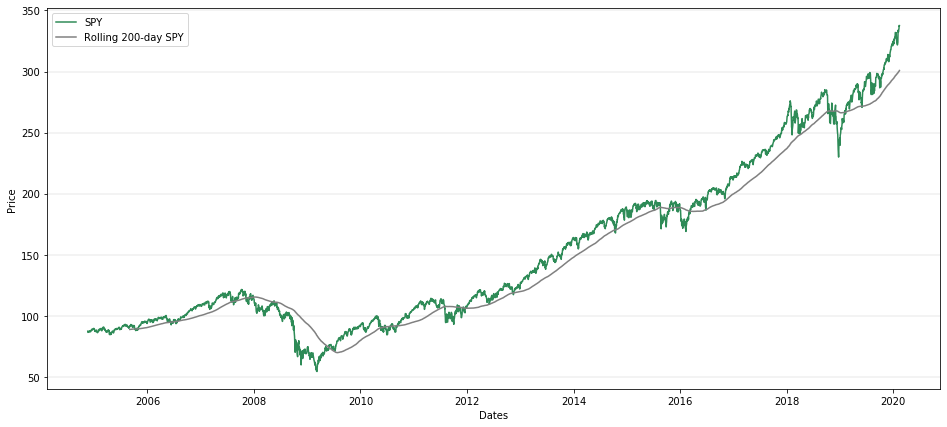

In [10]:
plt.figure(figsize = (16, 7))
plt.plot(close_data['SPY'], label = 'SPY', color = 'seagreen')
plt.plot(mavg.index, mavg, label = f'Rolling {window}-day SPY', color = 'gray')
plt.ylabel('Price')
plt.xlabel('Dates')
plt.grid(axis = 'y', lw = 0.3)
plt.legend(loc = 'best');

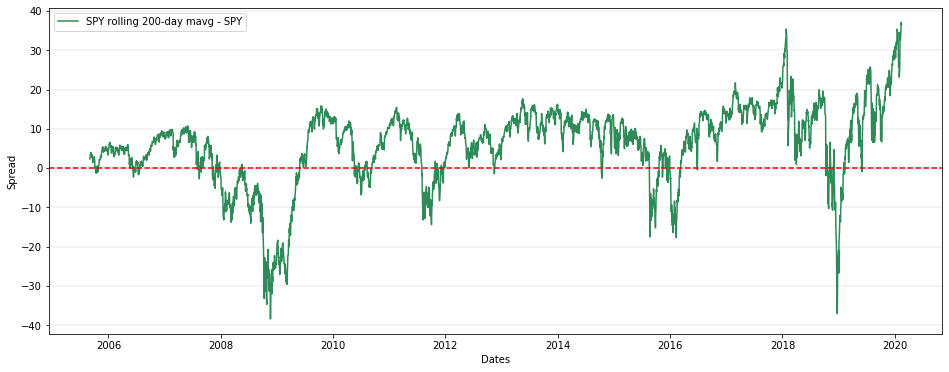

In [6]:
plt.figure(figsize = (16, 6))
plt.plot(spread.index, spread, label = f'SPY rolling {window}-day mavg - SPY', color = 'seagreen')
plt.ylabel('Spread')
plt.xlabel('Dates')
plt.axhline(color = 'r', ls = '--')
plt.grid(axis = 'y', lw = 0.3)
plt.legend(loc = 'best');

# 2x leverage

- Uses SPDR Gold Shares (GLD) and iShares 20+ Year Treasury Bond ETF (TLT) as 'safe havens'

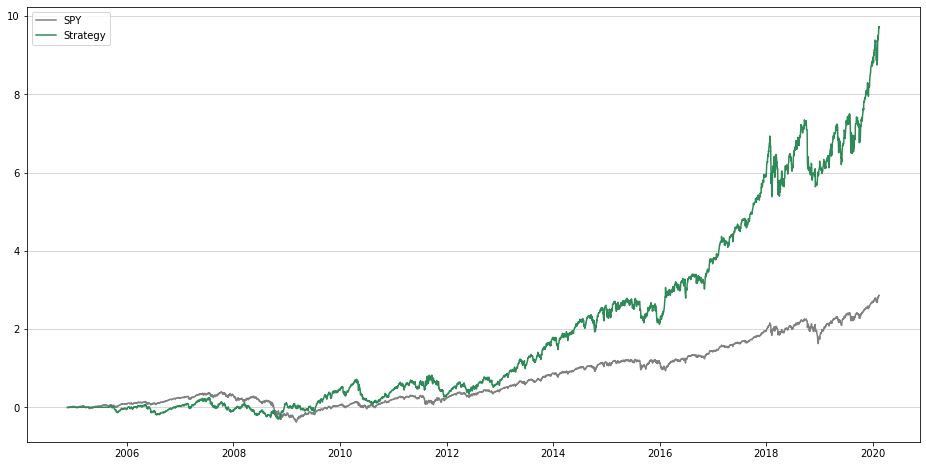

In [7]:
# buffer = 0.05
# upper_mavg = (mavg * (1 + buffer))
# lower_mavg = (mavg * (1 - buffer))

signal = pd.DataFrame(index = mavg.index)
signal['above_mavg'] = close_data['SPY'] > mavg
signal['below_mavg'] = close_data['SPY'] < mavg
# signal['above_buffer'] = close_data['SPY'] > upper_mavg
# signal['below_buffer'] = close_data['SPY'] < lower_mavg

bmk_ret = close_data.pct_change()

pos = pd.DataFrame(index = mavg.index)
pos['SPY'] = 0
pos['TLT'] = 0
pos['GLD'] = 0
pos.loc[signal['above_mavg'], 'SPY'] = 2
pos.loc[signal['below_mavg'], 'TLT'] = 1
pos.loc[signal['below_mavg'], 'GLD'] = 1


port = pd.DataFrame(index = mavg.index)
port['SPY'] = bmk_ret['SPY'] * pos['SPY'].shift()
port['TLT'] = bmk_ret['TLT'] * pos['TLT'].shift()
port['GLD'] = bmk_ret['GLD'] * pos['GLD'].shift()

port['port'] = port.sum(axis = 1)

# start_date = '2010-01-01'
# end_date = yday

cum_bmk_ret = np.cumprod(1 + bmk_ret.loc[start_date:, 'SPY']) - 1
cum_port_ret = np.cumprod(1 + port.loc[start_date:, 'port']) - 1

plt.figure(figsize = (16, 8))
plt.plot(cum_bmk_ret, label = 'SPY', color = 'gray')
plt.plot(cum_port_ret, label = 'Strategy', color = 'seagreen')
plt.legend(loc = 'best')
plt.grid(axis = 'y', lw = 0.5)
plt.show()

In [8]:
def apr(ts):
    '''
    Input: a daily return time series
    Output: an annualised percentage return
    '''
    return np.prod(1 + ts) ** (252 / len(ts)) - 1
    
def sharpe(ts):
    '''
    Input: a daily return time series
    Output: an annualised sharpe ratio
    '''
    return np.sqrt(252) * np.mean(ts) / np.std(ts)

def max_dd(ts):
    '''
    Input: a daily return time series
    Output: max drawdown, max drawdown duration, index of max drawdown
    '''
    cum_ret = np.cumprod(1 + ts) - 1
    
    high_water_mark = np.zeros(cum_ret.shape)
    draw_down = np.zeros(cum_ret.shape)
    draw_down_duration = np.zeros(cum_ret.shape)
    
    for t in np.arange(1, cum_ret.shape[0]):
        high_water_mark[t] = np.maximum(high_water_mark[t - 1], cum_ret[t])
        draw_down[t] = (1 + cum_ret[t]) / (1 + high_water_mark[t]) - 1
        if draw_down[t] == 0:
            draw_down_duration[t] = 0
        else:
            draw_down_duration[t] = draw_down_duration[t - 1] + 1 # adds another day
    
    max_dd, i = np.min(draw_down), np.argmin(draw_down) # 'draw_down' < 0 always
    max_ddd = np.max(draw_down_duration)
    
    return max_dd, max_ddd, i

In [9]:
strat = port.loc[start_date:, 'port']
bmk = bmk_ret.loc[start_date:, 'SPY']

strat_apr = apr(strat)
strat_sharpe = sharpe(strat)
strat_dd, strat_ddd, _ = max_dd(strat)

bmk_apr = apr(bmk)
bmk_sharpe = sharpe(bmk)
bmk_dd, bmk_ddd, _ = max_dd(bmk)

print('Asset\t\tAPR\tSharpe\tMax DD\tMax DDD')
print(f'Strategy\t{round(strat_apr * 100, 2)}%\t{round(strat_sharpe, 4)}\t{round(strat_dd * 100, 2)}%\t{strat_ddd} days')
print(f'Benchmark\t{round(bmk_apr * 100, 2)}%\t{round(bmk_sharpe, 4)}\t{round(bmk_dd * 100, 2)}%\t{bmk_ddd} days')

Asset		APR	Sharpe	Max DD	Max DDD
Strategy	16.87%	0.7263	-44.09%	540.0 days
Benchmark	9.28%	0.5779	-55.19%	1223.0 days


#### Conclusion

- Total returns can be improved with leverage. Capping leverage at 2 helps prevent strategy isn't wiped out during drawdowns
- Risk-adjusted returns are better than buy-and-hold, although they are not sensational. 
- Max Drawdown is actually less than buy-and-hold, suggesting the 200-day mavg rotation into 'safe havens' is worthwhile
